# Gaussian Thermals with Partial Knowledge
Assume:
* thermals are Gaussian-shaped with a certain center, amplitude, and standard deviation (same in both directions)
* we know point measurements of the vertical velocity along our path at certain intervals

Try to find the center, amplitude, and standard deviation of the thermal we run into.

#### Main Problem for Non-Discretized Thermal Representation
I have f(x,y) describing the thermal vertical velocities.  
We take measurements at discrete points along a path.  
How do I provide these measurements as observations?

    f(x1,y1)=v1
    f(x2,y2)=v2
    ...

    measurements = [(x1,y1,v1),(x2,y2,v2),...]
    
    deterministic_velocity(measurements, thermal_position, thermal_sd)
      by_model = []
      for (x,y,v) in measurements:
          by_model.append((x,y,gaussian_distribution(thermal_position, thermal_sd)(x,y)))

#### Changes from Square Thermals to Gaussian Thermals
* Gaussian function, vertical_velocity(thermal_position, thermal_sd)
* Create velocity field, true_vel_function = createVelocityField([(x1,y1,v1,sd1),(x2,y2,v2,sd2),...])
* Create 3D visualization of velocity field
* Create path through the field (points? parametric function? straight line?)
* Create visualization of path
* Take measurements on a path through the field, measurements = takeMeasurements(true_vel_function, path)
* Make deterministic velocity function for observations
* Observe!


#9 Position: (0, -30), Observed:
[(0, 0), (5, 5), (10, 10), (15, 12), (20, 15), (30, 20), (45, -10), (25, -35), (0, -30)]
[ 5.41922277  4.6297628   2.97896286  2.21901555  1.93037532  1.88634332
  0.26246441  0.02269855  0.07641686]
 [-----------------100%-----------------] 10000 of 10000 complete in 4.8 sec

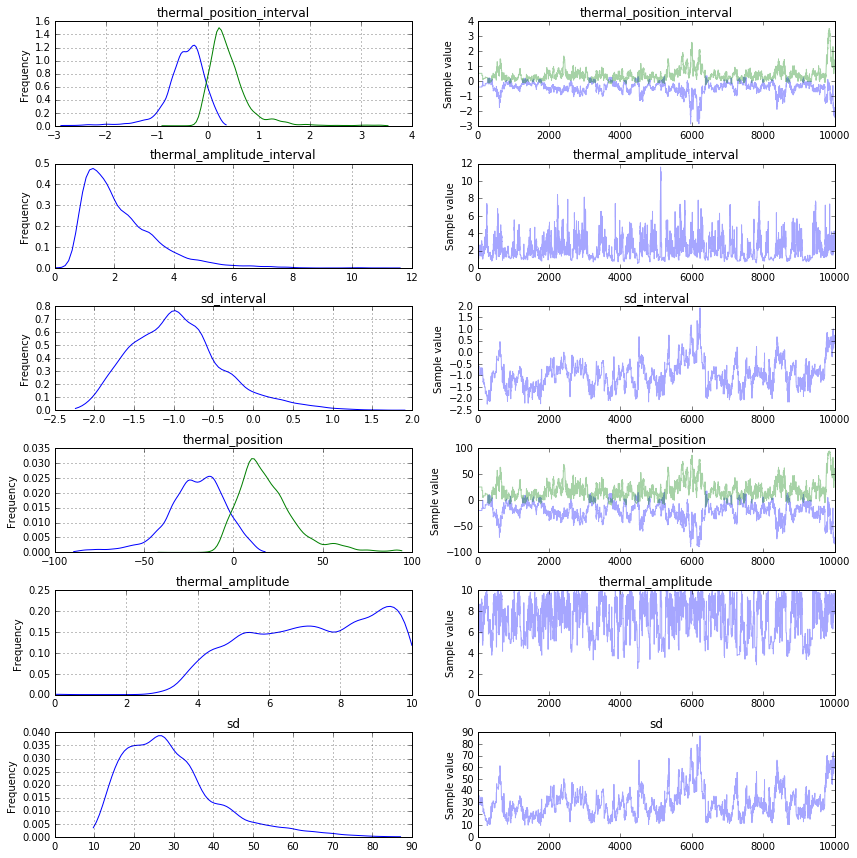

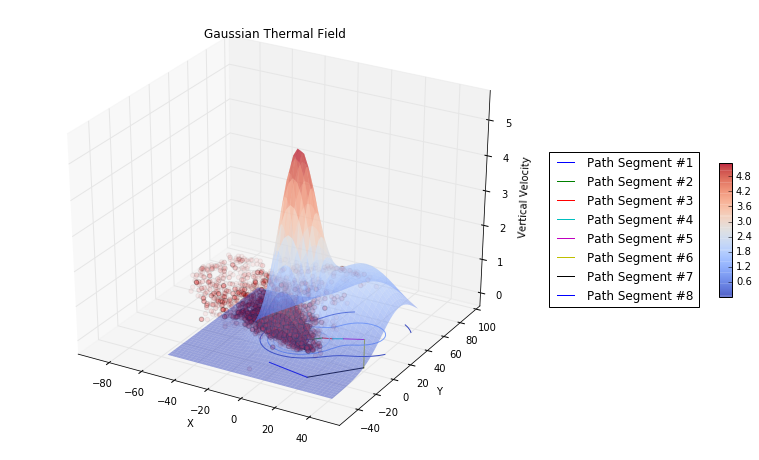

In [62]:
# For calculation
import sys
import random
import numpy as np
import pymc3 as pm
import scipy as sp
import theano
import theano.tensor as t

# For visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.path import Path
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

# Display plots in Jupyter
%matplotlib inline

# For reproducibility
random.seed(126)
np.random.seed(123)

# Vertical velocity as function of the thermal's position and width
def deterministicVelocity(path, measurements, thermal_position,
                          thermal_amplitude, thermal_sd):
    # Fix "Cannot compute test value" error, see: http://stackoverflow.com/a/30241668
    #theano.config.compute_test_value = 'ignore'
    
    # Create the function but already plug in some values we want to test with
    # See: https://www.quora.com/What-is-the-meaning-and-benefit-of-shared-variables-in-Theano
    x = theano.shared(np.array([x for x,y in path]))
    y = theano.shared(np.array([y for x,y in path]))
    
    # These functions now refer to the shared variables
    # Do not compile here, see: http://stackoverflow.com/q/30426216
    def gaussianTheano(xo, yo, amplitude, sigma_x, sigma_y):
        #xo = float(xo)
        #yo = float(yo)
        theta = offset = 0 # for now
        a = (pm.cos(theta)**2)/(2*sigma_x**2) + (pm.sin(theta)**2)/(2*sigma_y**2)
        b = -(pm.sin(2*theta))/(4*sigma_x**2) + (pm.sin(2*theta))/(4*sigma_y**2)
        c = (pm.sin(theta)**2)/(2*sigma_x**2) + (pm.cos(theta)**2)/(2*sigma_y**2)
        gauss = offset+amplitude*pm.exp(-1*(a*((x-xo)**2)+2*b*(x-xo)*(y-yo)+c*((y-yo)**2)))
        return gauss
    
    # Return the Theano function that we'll use when sampling
    return gaussianTheano(thermal_position[0], thermal_position[1],
                          thermal_amplitude, thermal_sd, thermal_sd)

# Zero offset, rotation, and same sigma in both x and y
def thermalEq(position, amplitude, sd):
    return gaussian(position[0], position[1], amplitude, sd, sd, 0, 0)

# See: http://stackoverflow.com/q/25342899
def gaussian(xo, yo, amplitude, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    gauss = lambda x,y: offset+amplitude*np.exp(-1*(a*((x-xo)**2)+2*b*(x-xo)*(y-yo)+c*((y-yo)**2)))
    return gauss

# Take measurements at the points along the path
# Input: field=[eq1, eq2, ...], path=[(x1,y1),(x2,y2),...]
# Output: [v1, v2, ...]
def takeMeasurements(field, path):
    measurements = np.empty(len(path))
    
    for i, pos in enumerate(path):
        measurement = 0
        
        for thermal in field:
            measurement += thermal(pos[0], pos[1])
        
        measurements[i] = measurement
    
    return measurements

#
# Create the visualization of the 3D thermal field, our path,
# and where we think the thermals are
#
def visualizeThermalField(field, path, trace, pos_min, pos_max):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection='3d')
    plt.title('Gaussian Thermal Field')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Vertical Velocity')

    # Evaluate thermal field equations over X,Y
    # See: http://matplotlib.org/examples/mplot3d/surface3d_demo.html
    X = np.arange(pos_min, pos_max, (pos_max-pos_min)/40)
    Y = np.arange(pos_min, pos_max, (pos_max-pos_min)/40)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros((len(X),len(Y)))
    
    for thermal in field:
        Z += thermal(X, Y)
    
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       alpha=0.5, linewidth=0, antialiased=True)
    
    fig.colorbar(surf, aspect=10, shrink=0.3)
    
    # Contours so we can see how it compares with the path
    # See: http://matplotlib.org/examples/mplot3d/contour3d_demo3.html
    cset = ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.coolwarm)
    #cset = ax.contour(X, Y, Z, zdir='x', offset=pos_min, cmap=cm.coolwarm)
    #cset = ax.contour(X, Y, Z, zdir='y', offset=pos_max, cmap=cm.coolwarm)
    
    # Plot the path
    # See: http://matplotlib.org/examples/mplot3d/lines3d_demo.html
    #ax.plot(X, Y, Z)
    
    # Plot the path as line segments
    # See: http://stackoverflow.com/a/11541628
    for i in range(1, len(path)):
        ax.plot([path[i-1][0], path[i][0]], [path[i-1][1],path[i][1]],
                zs=[0,0], label='Path Segment #'+str(i))
    
    # Put legend outside the graph
    # See: http://stackoverflow.com/a/4701285
    #
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # The learned values
    plt.scatter(trace["thermal_position"][:,0], trace["thermal_position"][:,1],
                alpha=0.05, c="r")

#
# Describe the thermal field, generate a path through it, and learn at
# each step in the path where we think the thermals are
#
thermals = [thermalEq((0,0), 5, 10),
            thermalEq((25,25), 2, 20)]
path = [(0,0), (5,5), (10,10), (15,12), (20,15),
        (30,20), (45,-10), (25,-35), (0,-30)]
measurements = takeMeasurements(thermals, path)

traces = []

#for key, position in enumerate(path):
if True:
    # At the moment just do it at the end of the path
    key = len(path)
    position = path[-1]
    
    with pm.Model() as model:
        # Priors
        # See: http://stackoverflow.com/q/25342899
        thermal_position = pm.Uniform('thermal_position',
                                      lower=-100, upper=100, shape=2)
        thermal_amplitude = pm.Uniform('thermal_amplitude',
                                       lower=-10, upper=10)
        thermal_sd = pm.Uniform('sd', lower=0.1, upper=100)

        # Measurements and path up to this point
        path_history = path[:key+1]
        measurement_history = measurements[:key+1]
        
        # When sampling, look at the values of the test thermal field at the points
        # we have taken measurements at.
        velocity = deterministicVelocity(path_history, measurement_history,
                                         thermal_position, thermal_amplitude,
                                         thermal_sd)

        # Observe the vertical velocities
        thermal_vert_vel = pm.Normal('thermal_vert_vel', mu=velocity,
                                     observed=measurement_history)

        # Debugging
        print()
        print("#", key, " Position: ", position, ", Observed:", sep="")
        print(path_history)
        print(measurement_history)
        sys.stdout.flush()

        # Sample this to find the posterior, note Metropolis works with discrete
        step = pm.Metropolis()
        traces.append(pm.sample(10000, step=step, progressbar=True))
        pm.traceplot(traces[-1]);
        plt.show()
        visualizeThermalField(thermals, path_history, traces[-1], -50, 50)
        plt.show()